In [5]:
# Data Augmentation
import tensorflow as tf

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../images/weatherImage/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../images/weatherImage/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1048 files belonging to 4 classes.
Using 839 files for training.
Found 1048 files belonging to 4 classes.
Using 209 files for validation.


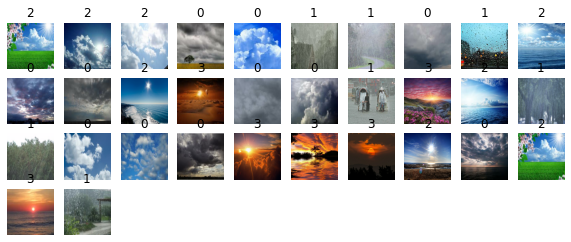

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(len(images)):
        ax = plt.subplot(10, 10, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [61]:
# tf.keras.layers.experimental.preprocessing 
# tf.keras.preprocessing.image.ImageDataGenerator 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # 以每一張feature map為單位將平均值設為0
        samplewise_center=False,  # set each sample mean to 0
        # 以每一張feature map為單位將數值除以其標準差(上述兩步驟就是我們常見的Standardization)
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,  # 將输入的每個樣本除以其自身的標準差。
        zca_whitening=False,  # dimesion reduction
        rotation_range=0.1,  # 隨機旋轉圖片
        zoom_range=0.1,  # 隨機縮放範圍
        width_shift_range=0.1,  # 水平平移，相對總寬度的比例
        height_shift_range=0.1,  # 垂直平移，相對總高度的比例
        horizontal_flip=False,  # 一半影象水平翻轉
        vertical_flip=False)  # 一半影象垂直翻轉


from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


In [67]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    creatModel =  keras.Model(inputs, outputs)
    creatModel.summary()
    return creatModel


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_11 (Sequential)     (None, 180, 180, 3)  0           ['input_6[0][0]']                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 180, 180, 3)  0           ['sequential_11[5][0]']          
                                                                                                  
 conv2d_30 (Conv2D)             (None, 90, 90, 32)   896         ['rescaling_5[0][0]']      